## Introduction

This notebook is the result of my final project for my Business Analytics Course.

<br>_The Project_</br>
Using consumer complaint data from the Consumer Financial Protection Bureau (CFBA), build a machine learning model to help banks identify which consumer complaints will result in a dispute.

<br>_Data Source_</br>
* Data can be downloaded here: https://www.consumerfinance.gov/data-research/consumer-complaints/
* The data used in this notebook was filtered to only include data from the five banks generally considered to be the five largest banks in the US. Namely, Bank of America, National Association, Wells Fargo & Company, JPMorgan Chase & Co., Citibank, U.S. Bancorp.
* The data is limited from 2012-March 2017 because the CFPB stopped collecting data for customer disputes in April 2017.

<br>_Other details_</br>
* On average, it costs the banks 100 USD to resolve, respond and close a complaint that is not disputed.
* On the other hand, it costs banks an extra 1500 USD to resolve a complaint if it has been disputed.
* If a complaint is picked up for "extra diligence" (from the machine learning model), it costs the banks an extra 90 USD to perform the additional diligence steps to resolve the complaint in a way that hopefully won't result in a dispute.


In [1]:
## import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics

## Exploratory Data Analysis

In [2]:
# import data
df = pd.DataFrame(pd.read_csv('complaints_25Nov21.csv'))
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


In [3]:
# Find the responses we have for the target variable
df['Consumer disputed?'].value_counts()

No     162357
Yes     44903
Name: Consumer disputed?, dtype: int64

In [4]:
# Null-values?
df.isnull().sum()

Date received                        0
Product                              0
Sub-product                      43015
Issue                                0
Sub-issue                       196913
Consumer complaint narrative    177869
Company public response         148802
Company                              0
State                             2194
ZIP code                          9286
Tags                            178995
Consumer consent provided?      155947
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
dtype: int64

**Initial thoughts**
With 207260 rows of data, we have a huge dataset. While this is very exciting I also need to be very selective with how I preprocess the data, which features I select or feature engineer into my model given that I'm just working with my personal computer.

Columns:
* Date received - drop
* Products - keep
* Sub-product - unsure
* Issue - drop (issues are related to products, let's avoid redundancy)
* Sub-issue - drop (high cardinality, the big picture is likely captured by Products)
* Consumer complaint narrative - keep for FE (given the size of our dataset, closely analyzing the narrative will be computationally very costly but let's find another way to use this data)
* Company public response - keep
* Company - drop (the assignment specified building a model for the five biggest banks, not for any individual bank; the dataset includes only complaints from these five banks)
* State - keep for FE (Again, this this column of categorial data has high cardinality but includes nonetheless probably useful data)
* ZIP code - drop
* Tags - keep for FE
* Consumer consent provided? - drop
* Submitted via - keep for FE
* Data sent to company - drop
* Company response to consumer - keep for FE
* Timely response? - drop
* Consumer disputed? - Target variable
* Complaint ID - drop


/global/homes/d/dornamu/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


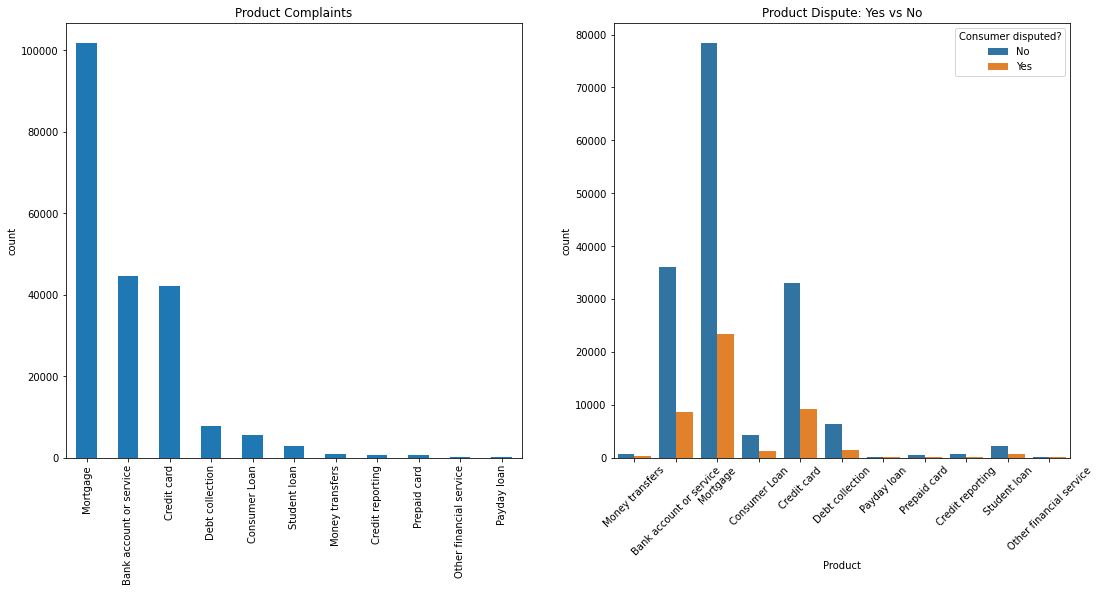

In [5]:
# Product and Complaint Disputed
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Product'].value_counts().plot.bar(ax=ax[0]) 
ax[0].set_title('Product Complaints')
ax[0].set_ylabel('count')
sns.countplot('Product',hue='Consumer disputed?',data=df,ax=ax[1])

ax[1].set_title('Product Dispute: Yes vs No')
plt.xticks(rotation=45)
plt.show()

In [6]:
# function to see the how frequently each product gets dipsuted
def get_percent(prod):
    prod_yes = len(df.loc[(df['Product']==prod) & (df['Consumer disputed?'] == 'Yes')])
    return float(prod_yes/len(df.loc[df['Product']==prod]))

In [7]:
product_key = df['Product'].unique().tolist()
values = [get_percent(prod) for prod in product_key]
product_dict = dict(zip(product_key, values))
    
sorted(product_dict.items(), key=lambda x: x[1], reverse=False)

[('Payday loan', 0.1566265060240964),
 ('Credit reporting', 0.16734143049932523),
 ('Prepaid card', 0.1700787401574803),
 ('Debt collection', 0.18916168426408853),
 ('Bank account or service', 0.19233529174328384),
 ('Consumer Loan', 0.21405228758169934),
 ('Credit card', 0.21689459837406083),
 ('Student loan', 0.22365666434054432),
 ('Mortgage', 0.229720692368214),
 ('Other financial service', 0.23706896551724138),
 ('Money transfers', 0.24165707710011508)]

When I was experimenting with developing a new feature using the 'Product' data I found that encoding by the % of the complaints that were disputed by product category performed better than an ordinal ranking of this frequency. Consequently, I included the former in my model.

Text(0.5, 1.0, 'Method of Submission and Disputes')

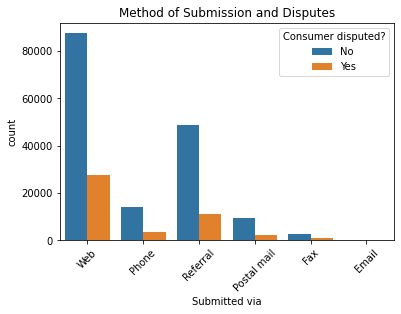

In [8]:
# Submitted via
ax = sns.countplot(x='Submitted via', data=df, hue='Consumer disputed?')
#plt.title('Cut vs color');
plt.xticks(rotation=45)
ax.set_title('Method of Submission and Disputes')

In [9]:
# function to see the distrubution how the dipsuted complaints were submitted
def get_percent_s(prod):
    prod_yes = len(df.loc[(df['Submitted via']==prod) & (df['Consumer disputed?'] == 'Yes')])
    return float(prod_yes/len(df.loc[df['Submitted via']==prod]))

In [11]:
submission_key = df['Submitted via'].unique().tolist()
values = [get_percent_s(s) for s in submission_key]
submission_dict = dict(zip(submission_key, values))
    
sorted(submission_dict.items(), key=lambda x: x[1], reverse=False)

[('Referral', 0.18330031230061453),
 ('Postal mail', 0.1929428124456805),
 ('Phone', 0.19332572732458642),
 ('Fax', 0.23226900254309127),
 ('Web', 0.23930962524997826),
 ('Email', 0.27350427350427353)]

Again, while modeling I found that encoding the 'Submitted via' data by the % of the complaints that were disputed by submission method performed better than an ordinal ranking of the frequency.

In [12]:
# Sub issue
len(set(df['Sub-issue'].values.tolist()))

58

Very high cardinality - dropping this feature.

In [13]:
# Tags
tags = list(set(df['Tags'].values.tolist()))
tags

[nan, 'Older American, Servicemember', 'Servicemember', 'Older American']

In [14]:
# Consumer Complaint Narrative
ccn = df['Consumer complaint narrative'].values.tolist()

In [15]:
# what percentage of ccns disputed?
ccn_yes = len(df.loc[(df['Consumer complaint narrative'].notnull()) & (df['Consumer disputed?'] == 'Yes')])
ccn_yes/len(df.loc[(df['Consumer complaint narrative'].notnull())])

0.23939301146609507

The majority of the complaints were not disputed. To adequately train the model, we must try to balance the classes.

In [16]:
# function to get word count complaint
def get_wc(complaint):
    print(complaint)
    return len(complaint)

In [17]:
word_count = df['Consumer complaint narrative'].str.split().str.len()
df['CCN wordcount'] = word_count

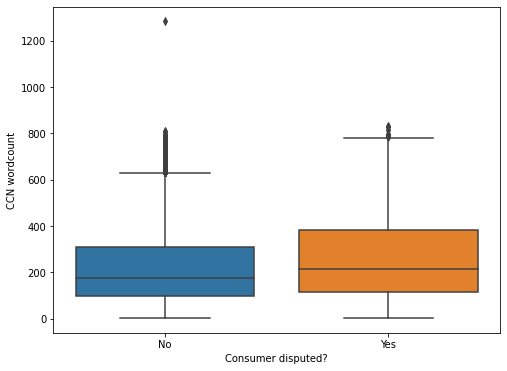

In [18]:
# Create the boxplots
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(y='CCN wordcount', x='Consumer disputed?', data=df);
# To keep in mind, when input data contains NaN, it will automaically be filled with 0

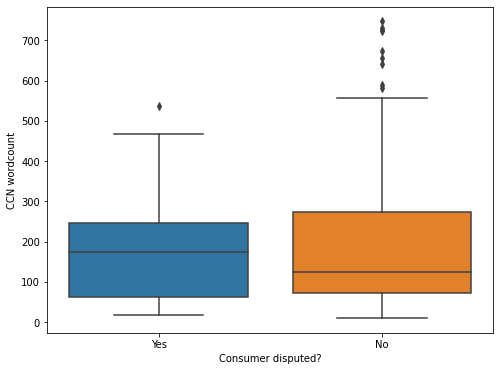

In [19]:
# Compare with previous plot, this time don't fill in 0s for NaN
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(y='CCN wordcount', x='Consumer disputed?', data=df.dropna());

Generally, complaints with higher word counts are less likely to get disputed. 
Earlier I considered grouping the word count but now I'm thinking that our model won't have alot of numerical data and that would be difficult for humans to choose a good cut-off for groups - leave 'CNN' Wordcount as its own feature but normalize it to improve performance in the model.

In [20]:
# what percentage of older american and service member disputed?
tag_yes = len(df.loc[(df['Tags'].isnull()) & (df['Consumer disputed?'] == 'Yes')])
tag_yes/len(df.loc[(df['Tags'].isnull())])

0.21392217659711166

That's also not unsignficant - it would be simple enough to create a column to flag whether or not the customer was tagged as an older american or a service member.

## Feature Engineering

In the previous section, I noted a couple of features I wanted to develop. Another feature that improved the performance of my model was one that takes into account the relationship between whether or not the banks provided some relief in response to the complaint and the ranking of the product in terms of disputed complaints. 

In [21]:
def get_state_sensitivity(state):
    # states with high dispute rates
    vs = ['MP', 'PW', 'AS']
    # states with modeate dispute rates
    ms = ['GU','HI','AA','FM','MS','NE','OR','AK','DE']
    # states with low dispute rates
    ls = ['AP','NM','MT','SD','MH','GA','NH','WV','KS','ID','LA','WY']
    if state in vs:
        return 0.5
    elif state in ms:
        return 0.24
    elif state in ls:
        return 0.19
    else:
        return 0.22

In [22]:
# function to incdicate if response is without relief
def is_wr(response):
    if response == 'Closed without relief' or response == 'Closed with non-monetary relief':
        return 2
    else:
        return 0

In [23]:
# Feature engineering: test normalizing the word count
def new_features(df):
    
    # Flag whether or not there were tags (indicates that the customer is a service member or an older american, or both)
    df['Is SM or OA'] = np.where(df['Tags'].isnull(),0,1)
    
    # Get wordcount of customer complaint
    word_count = df['Consumer complaint narrative'].str.split().str.len()
    df['CCN wordcount'] = word_count
    # Impute missing values with the mean()
    df['CCN wordcount'].fillna(value=df['CCN wordcount'].mean(), inplace=True)  
    # Apply log transformation on wordcount to noramlize the distribution
    df['log_transform_CNN_wc'] = np.log10(df['CCN wordcount'])
    
    # Get frequency encoding for 'State'
    df['State'].fillna(value=df['State'].mode(), inplace=True)
    df['State Sensitive'] = df['State'].map(get_state_sensitivity)
    
    # New feature: complaint relief * product ordinality
    # Define a dictionary for the ordinality of disputed products
    enc_dict_p = {'Payday loan':1,'Credit reporting':2,'Prepaid card':3,'Debt collection':4,'Bank account or service':5,\
               'Consumer Loan':6,'Credit card':7,'Student loan':8, 'Mortgage':9,'Other financial service':10, 'Money transfers':11}
    # Create the mapped values in a new column
    df['Product Ordinal'] = df['Product'].map(enc_dict_p)
    df['Non Relief'] = df['Company response to consumer'].map(is_wr)
    df['Product-Non Relief'] = df['Product Ordinal'] * df['Non Relief']
    
    # Drop columns
    df.drop(columns=['Tags', 'Consumer complaint narrative', 'CCN wordcount','State', 'Non Relief', 'Product Ordinal'], inplace = True)
    
    return df

In [24]:
# Function to encode the data
def encode(df):
    # Define a dictionary for encoding the frequency of disputed products
    enc_dict_p_freq = {'Payday loan':0.157,'Credit reporting':0.167,'Prepaid card':0.170,'Debt collection':0.189,'Bank account or service':0.192,\
               'Consumer Loan':0.214,'Credit card':0.217,'Student loan':0.224, 'Mortgage':0.230,'Other financial service':0.237, 'Money transfers'\
               :0.242}
    # Create the mapped values in a new column
    df['Product Frequecy'] = df['Product'].map(enc_dict_p_freq)
    
    # Define a dictionary for encoding the freuqnecy of how disputed complaints were submitted
    enc_dict_s = {'Referral':0.183,'Postal mail':0.193,'Phone':0.193,'Fax':0.232,'Web':0.239,'Email':0.274}
    # Create the mapped values in a new column
    df['Method Frequency'] = df['Submitted via'].map(enc_dict_s)
    
    # Label encode the target variable
    le = preprocessing.LabelEncoder()
    df['Consumer disputed?'] = le.fit_transform(df['Consumer disputed?'])
    
    # drop columns
    df.drop(columns=['Product', 'Submitted via'],inplace = True)
    
    # Encode the remaining categorical variables
    df = pd.get_dummies(df)
    
    return df

In [25]:
def clean(df):
    ## Fill-in NaN in target variable
    df['Consumer disputed?'].fillna('No', inplace=True)
    df['Consumer disputed?'] = df['Consumer disputed?'].astype('category')
    
    # drop cols that won't be used
    cols_drop = ['Date received','Company public response','Company','Consumer consent provided?', \
                 'Date sent to company','Complaint ID','ZIP code','Sub-issue', 'Sub-product', 'Issue']
    df.drop(columns=cols_drop, inplace = True)
    return df

In [26]:
## import, preprocess, and split the data

df = pd.DataFrame(pd.read_csv('complaints_25Nov21.csv', engine='python'))
    
# Preprocessing
df = clean(df)
df = new_features(df)

df = encode(df)
df

,Consumer disputed?,Is SM or OA,log_transform_CNN_wc,State Sensitive,Product-Non Relief,Product Frequecy,Method Frequency,Company response to consumer_Closed,Company response to consumer_Closed with explanation,Company response to consumer_Closed with monetary relief,Company response to consumer_Closed with non-monetary relief,Company response to consumer_Closed with relief,Company response to consumer_Closed without relief,Company response to consumer_Untimely response,Timely response?_No,Timely response?_Yes
0,0,0,2.394452,0.22,0,0.242,0.239,0,1,0,0,0,0,0,0,1
1,0,1,2.568202,0.22,0,0.192,0.239,0,1,0,0,0,0,0,0,1
2,0,0,2.549003,0.22,0,0.192,0.239,0,0,1,0,0,0,0,0,1
3,1,1,2.377722,0.22,0,0.230,0.193,0,1,0,0,0,0,0,0,1
4,0,0,2.377722,0.19,0,0.230,0.183,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,0,0,2.377722,0.22,0,0.189,0.239,0,1,0,0,0,0,0,0,1
207256,1,0,2.377722,0.22,18,0.230,0.183,0,0,0,0,0,1,0,0,1
207257,0,0,2.377722,0.19,0,0.224,0.239,0,1,0,0,0,0,0,0,1
207258,0,0,2.827369,0.22,10,0.192,0.239,0,0,0,1,0,0,0,0,1


## Modelling

In [27]:
# Define X and y
X = df
y = X.pop('Consumer disputed?')

# Preform Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Undersample the majority class of the target variable
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)


In [28]:
y_train.sum()/len(y_train) #just checking that the '1' category is exactly 50% of the training set

0.5

For this classification problem, I used the XGBoost ML model. I also tried SVM and Linear Discriminant Analysis models but the XGBoost performed the best. 

[07:50:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.54      0.65     32594
           1       0.27      0.62      0.37      8858

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.72      0.55      0.59     41452



/global/homes/d/dornamu/.conda/envs/myenv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


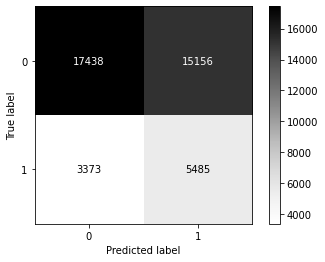

In [29]:
# Fit the model
model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic', n_estimators=100, learning_rate=0.05, n_jobs=4, max_depth = 5)
model_xgb.fit(X_train, y_train, early_stopping_rounds=7,eval_set=[(X_test, y_test)], verbose=False)

# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

# Check the classification report and the confusion matrix
print(classification_report(y_true = y_test, y_pred = pred))
plot_confusion_matrix(model_xgb, X = X_test, y_true = y_test, cmap='Greys');

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

## Performance and Threshold Analysis

In classification problems, especially in a business context, evaluating a model performance in terms of accuracy is not sufficient. For example, in this case, the price of false negatives (1500 USD) is much steeper than the cost of a false negative (90 USD). Thus, we want a higher recall rate (TP/TP + FN) for disputed claims, even if it means lower precision (TP/TP +FP).

One way to use visualization to develop some intuition about this is to use the AUC - ROC Curve (Area under the Curve - Receiver Operating Characteristics). The higher the AUC, the better the model is at classification. The curve is plotted with True Positive Rate against the False Positive Rate. This is not the same as recall and precision, but we can follow the principle of achieving a high True Positive rate even if the False Positive Rate goes up.

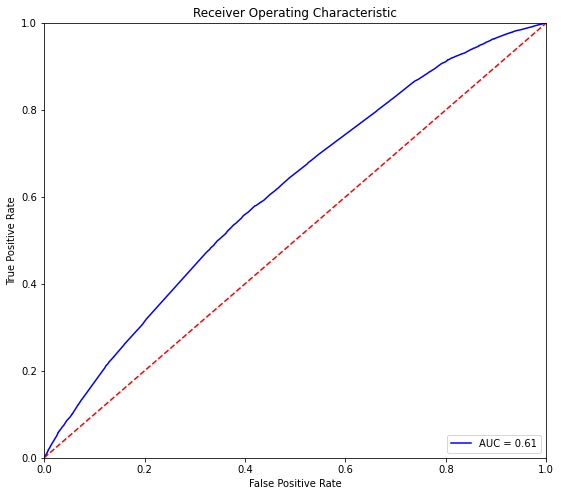

In [30]:
metrics.roc_auc_score(y_test, pred_prob)

# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

With an AUC value of approx. 0.61 our model does have some skill. It is worth noting that even if there is a situation in which alot of data is available, such as this one, it does not necessarily guarantee that the data will have alot of predictive power. To give a few examples, all the Mutual Information scores for the columns in the dataset were practically 0, and the model performs better when undersampling class 0 of the target variables than when using SMOTE (synthetic minority Over-sampling) for class 1. 

Nevertheless, let's make this model as useful as possible in the business context. As the AUC curve is pretty smooth, indicating that there are no noteworthy tradeoffs between the true positive and false positive rate. Let's explore how changing the threshold for the target variable affects costs and potential savings. 

In [31]:
## Define cost function to aid our threshold analysis

# False Negatives
def get_cost_fn(count):
    return count*1500

# False Positives
def get_cost_fp(count):
    return count*90

# True Negatives
def get_cost_tn(count):
    return count*0

# True Positives
def get_cost_tp(count):
    return count*-1410 #1500-90

## Define function to get the costs
def get_total_cost(cm):
    total_cost = 0
    
    # Negatives
    n = list(cm[0])
    # Positives
    p = list(cm[1])
    
    # False negatives
    total_cost += get_cost_fn(p[0])
    # False positives
    total_cost += get_cost_fp(n[1])
    # True postives
    total_cost += get_cost_tp(p[1])
    
    return total_cost

In [32]:
## Testing Extreme Cases

# Set threshold for identifying class 1
threshold = 1
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)

print(classification_report(y_true = y_test, y_pred = pred))

tc = get_total_cost(cm)
print('Total Cost =',tc)

Confusion Matrix : 
 [[32594     0]
 [ 8858     0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     32594
           1       0.00      0.00      0.00      8858

    accuracy                           0.79     41452
   macro avg       0.39      0.50      0.44     41452
weighted avg       0.62      0.79      0.69     41452

Total Cost = 13287000


/global/homes/d/dornamu/.conda/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/homes/d/dornamu/.conda/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/global/homes/d/dornamu/.conda/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

To emphasize how accuracy is not the best metric of measurement, accuracy is highest when everything is classified according to the majority class, namely, not disputed. Making a new policy to just add an extra step into the resolution process renders our model useless not to mention this might not be the best use of resources for the bank. More nuance needs to be taken into account when evaluating our models.

We've already established that a high recall rate is important. Let's take a closer look at how the various costs and savings the ML is making at different thresholds.

In [33]:
## Plot the costs for all thresholds

# range() can only do integers
thresholds = [x * 0.05 for x in range(0, 20)]
costs = []
fp_costs = []
fn_loss = []
tp_savings = []


for t in range(len(thresholds)):
    # Set threshold for identifying class 1
    threshold = thresholds[t]
    # Create predictions.  Note that predictions give us probabilities, not classes!
    pred_prob = model_xgb.predict_proba(X_test)

    # We drop the probabilities for class 0, and keep just the second column
    pred_prob = pred_prob[:,1]

    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, pred)
    
    # Negatives
    n = list(cm[0])
    # Positives
    p = list(cm[1])
    
    # Get how much resources was spent on false positives
    fp = get_cost_fp(n[1])
    # Get how much money was lost on false negatives
    fn = get_cost_fn(p[0])
    # Get how much money was saved on true positives
    tp = get_cost_tp(-1*p[1])
    
    tc = get_total_cost(cm)
    
    fp_costs.append(fp) 
    fn_loss.append(fn)
    tp_savings.append(tp)
    
    costs.append(tc)

Text(0, 0.5, 'Extra Dilligence Cost')

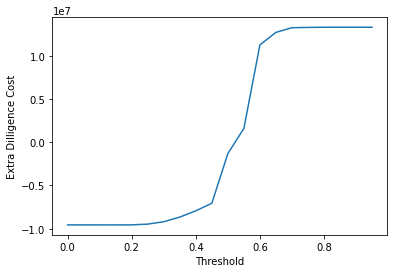

In [35]:
plt.plot(thresholds,costs)
plt.xlabel("Threshold")
plt.ylabel("Extra Dilligence Cost")

In the plot above the Y-axis represents the cost/savings at different thresholds on the x-axis. 

As it can be seen, the banks should hypothetically save the most if they set the model threshold to a low value. Nevertheless, going back to the point made previously, such a solution calls for even more resources when the point of this ML model is to help the banks use their resources efficiently.

The project document did not specify the amount of resources the banks were willing to spend on "extra diligence" but let's help provide them provide some guidance.

The above plot only took into account total costs. It is important to consider that the different kinds of classifications have different weights with True Positive Savings (1410 USD) and False Negative Costs (-1500 USD) having the strongest effect in the total cost function.

Let's plot the different savings and cost to better visualize at what threshold we are getting the most for our false-positive costs aka the hypothetical "budget."

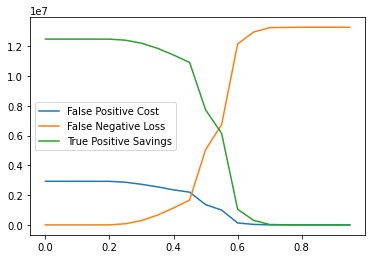

In [36]:
## Uncomment the lines above if you like to see the plot with line for a b udget

# value = 0
# budget = [value for x in range(0, 20)]
# plot lines
plt.plot(thresholds, fp_costs, label = "False Positive Cost")
plt.plot(thresholds, fn_loss, label = "False Negative Loss")
plt.plot(thresholds, tp_savings, label = "True Positive Savings")
#plt.plot(thresholds, budget, label = "Budget")
plt.legend()
plt.show()

<br>_True Positive Savings_ reflects the amount of money saved from correctly identifying a future disputed claim and then performing the extra dilligence steps to resolve it in a way that will not result in a dispute = 1410(1500-90) USD * true positives.</br>
<br>_False Negative Loss_ refers to the money lost from classifying future disputed claims as claims that will not be disputed = 1500 USD * false negatives .</br>
<br>_False Positive Cost_ is the cost from classifying a non-future disputed claim as a complaint that will be disputed and then performing the exta dilligence step on it = 90 USD * false positives.</br>

**Observations:**
* The higher the threshold, the lower the amount saved from using this model.
* The cost of incorrectly identifying false negatives almost mirrors true positive savings, which makes sense as 1410 USD (TP savings) is close to 1500 USD (FN loss)
* The cost of false positives remains relatively stable, and even decreases as the threshold increases, which makes sense because there are fewer false positives to catch.

The goal should be to maximize true positive savings while minimizing False-positive costs. Thus, You would likely want the threshold before the true positive savings takes a nose dive, which looks like it is somewhere between 0.4 and 0.5

In [38]:
# Plot the costs and savings for between 0.4-0.5
thresholds = [0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]
costs = []
fp_costs = []
fn_loss = []
tp_savings = []


for t in range(len(thresholds)):
    # Set threshold for identifying class 1
    threshold = thresholds[t]
    # Create predictions.  Note that predictions give us probabilities, not classes!
    pred_prob = model_xgb.predict_proba(X_test)

    # We drop the probabilities for class 0, and keep just the second column
    pred_prob = pred_prob[:,1]

    # Convert probabilities to 1s and 0s based on threshold
    pred = (pred_prob>threshold).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_test, pred)
    
    # Negatives
    n = list(cm[0])
    # Positives
    p = list(cm[1])
    
    # Get how much resources was spent on false positives
    fp = get_cost_fp(n[1])
    # Get how much money was lost on false negatives
    fn = get_cost_fn(p[0])
    # Get how much money was saved on true positives
    tp = get_cost_tp(-1*p[1])
    
    tc = get_total_cost(cm)
    
    fp_costs.append(fp) 
    fn_loss.append(fn)
    tp_savings.append(tp)
    
    costs.append(tc)


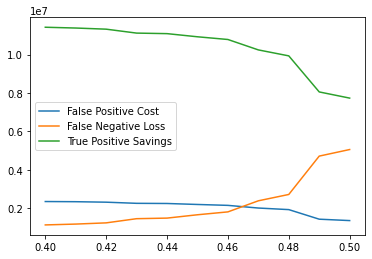

In [39]:
#budget = [1000000 for x in range(0, 11)]
# plot lines
plt.plot(thresholds, fp_costs, label = "False Positive Cost")
plt.plot(thresholds, fn_loss, label = "False Negative Loss")
plt.plot(thresholds, tp_savings, label = "True Positive Savings")
#plt.plot(thresholds, budget, label = "Budget")
plt.legend()
plt.show()

It looks like the best threshold value is around 0.46 - let's confirm ...

In [40]:
threshold_dict_tp = dict(zip(thresholds, tp_savings))
threshold_dict_tp

{0.4: 11419590,
 0.41: 11378700,
 0.42: 11319480,
 0.43: 11115030,
 0.44: 11086830,
 0.45: 10923270,
 0.46: 10782270,
 0.47: 10240830,
 0.48: 9930630,
 0.49: 8055330,
 0.5: 7733850}

In [41]:
threshold_dict_fp = dict(zip(thresholds, fp_costs))
threshold_dict_fp

{0.4: 2354760,
 0.41: 2345760,
 0.42: 2320740,
 0.43: 2261430,
 0.44: 2253060,
 0.45: 2201940,
 0.46: 2155140,
 0.47: 2016360,
 0.48: 1934550,
 0.49: 1436400,
 0.5: 1364040}

In [50]:
# Set threshold for identifying class 1
threshold = 0.46
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)

print(classification_report(y_true = y_test, y_pred = pred))

# Negatives
n = list(cm[0])
# Positives
p = list(cm[1])
    
# Get how much resources was spent on false positives
fp = get_cost_fp(n[1])
# Get how much money was saved on true positives
tp = get_cost_tp(-1*p[1])

print('True Positive Savings =',tp)
print('False Positive Costs =',fp)

Confusion Matrix : 
 [[ 8648 23946]
 [ 1211  7647]]
              precision    recall  f1-score   support

           0       0.88      0.27      0.41     32594
           1       0.24      0.86      0.38      8858

    accuracy                           0.39     41452
   macro avg       0.56      0.56      0.39     41452
weighted avg       0.74      0.39      0.40     41452

True Positive Savings = 10782270
False Positive Costs = 2155140


In conclusion, the model is the most useful to banks when the threshold value is approx. 0.46. Moreover, the banks can use this model as a starting point to in budgeting for how much resource needs to be pu aside for the "extra dilligence" step by looking at the false positive cost.

Let me know your thoughts and feedback! I would love to learn from you :)